# 作业二：实战CNN —— CIFAR-10图像分类


| 姓名 | 学号 | 贡献比重 | 分工 |
| :--: | :--: | :--: | :--: |
| 郑子帆 | 1120200822 | 25% | 初版代码编写 |
| 方辰 | 1120200731 | 0% |  |
| 张益宁 | 1120200827 | 25% | 美化排版 |
| 安禹堃 | 1120200860 | 25% | 参数调试 |
| 贾昌国 | 1120200664 | 25% | 模块手写 |

## 作业概述
&emsp;&emsp;本次作业为**CIFAR-10图像分类**，结合课上所学内容，我们选取其中比较有代表性和应用比较广泛的两个模型——**VGG**和**ResNet**模型进行微调进行训练，来实现对于CIFAR-10图像的分类。

&emsp;&emsp;具体而言，我们先借助图像处理工具对于数据集进行一些处理，提高模型的训练效果也有利于防止严重的过拟合。其次利用torch.nn模块实现了**VGG16**模型和**ResNet18**模型并对CIFAR-10测试集进行了分类。在这一过程中，进行了学习率、批量大小等超参数的调整，获得了较好的准确率。

&emsp;&emsp;在此之上，我们最后进行了分类的可视化，从测试集中随机选取30张图像，显示其标签和用不同模型分类得到的结果。

### 数据集介绍

&emsp;&emsp;**CIFAR-10** 是由 Hinton 的学生 Alex Krizhevsky 和 Ilya Sutskever 整理的一个用于识别普适物体的小型数据集。

&emsp;&emsp;该数据集一共包含:
*   **10** 个类别的 RGB 彩色图片：

&emsp;&emsp;&emsp;&emsp;飞机(airlane)、汽车(automobile)、鸟类(bird)、猫(cat)、鹿(deer)、狗(dog)、蛙类(rog)、马(horse)、船(ship)和卡车(truck)。
*   **32×32** 图片尺寸
*   **50000** 张训练图片
*   **10000** 张测试图片



In [130]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
import time

# CIFAR_URL是下载数据集的网址。
CIFAR_URL = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'

### 下载和缓存数据集

&emsp;&emsp;这里实现了几个函数来下载 **CIFAR-10** 数据集：

&emsp;&emsp;下面的`download`函数用来下载并解压缩数据集，
将数据集缓存在本地目录（默认情况下为`../data`）中。
如果缓存目录中已经存在此数据集文件，并且其名称与下载文件名匹配，
我们将使用缓存的文件，以避免重复的下载。

&emsp;&emsp;下载完成后函数执行解压缩，为避免重复解压缩，同样检查是否有文件名相匹配。

In [2]:
def downloadCIFAR():
    # 检查本地是否有重复文件下载
    if not os.path.exists('../data'):
        os.system('mkdir ../data')
        print('make dic')
    if not os.path.exists('../data/cifar-10-python.tar.gz'):
        print('downloading CIFAR')
        os.system('wget {}'.format(CIFAR_URL))
        os.system('mv ./cifar-10-python.tar.gz ../data/cifar-10-python.tar.gz')
    else:
        print('CIFAR exist')

    # 检查解压后文件名是否重复   
    if not os.path.exists('../data/cifar-10-batches-py'):
        print('unpacking CIFAR')
        os.system('tar -zxvf ../data/cifar-10-python.tar.gz -C ../data/')
    else:
        print('CIFAR unpacked')
        
downloadCIFAR()

make dic
downloading CIFAR
unpacking CIFAR


### 数据集的处理及转换

下面的代码用作处理数据。
 
&emsp;&emsp;**CIFAR**数据集会自动保存为 `pkl` 格式，为了将其转换成可读的python列表，需要加载 `pickle` 库来读取文件，下面的 `unpickle` 函数实现了读取 `pkl` 文件并返回 `List` 的功能。

&emsp;&emsp;为了增加数据的可读性以及验证读取数据的正确性，下面的 `show_img` 函数实现了读取数据并展示图片和label的功能

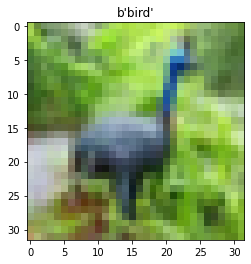

In [4]:
# 读取pkl文件
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# 展示图片与标签
def show_img(num):              
    
    dict = unpickle('../data/cifar-10-batches-py/data_batch_1')
    info = unpickle('../data/cifar-10-batches-py/batches.meta')
    # 记录图片
    np_img = dict[b'data'][num].reshape([3, 32, 32])
    np_img = np_img.transpose(1, 2, 0)
    # 记录标签
    label = info[b'label_names'][dict[b'labels'][num]]
    
    plt.imshow(np_img)
    plt.axis('on')
    plt.title(label)
    plt.show()

    
show_img(6)

获取到全部**CIFAR**数据集的列表形式后，分别将其中训练集部分，测试集部分储存为单独的Tensor，方便后续利用pytorch库进行处理。

下面的代码实现了将读取到的数据转为torch.tensor以及一系列形状操作。

In [131]:
# 得到一个batch文件的数据
def get_label_data(train_val, num=0):          
    if train_val == 'train':
        dict = unpickle('../data/cifar-10-batches-py/data_batch_{}'.format(num))
        return torch.tensor(dict[b'labels'], dtype=torch.long), torch.tensor(dict[b'data'],dtype=torch.float32).reshape(10000, 3, 32, 32)
    else:
        dict = unpickle('../data/cifar-10-batches-py/test_batch')
        return torch.tensor(dict[b'labels'], dtype=torch.long), torch.tensor(dict[b'data'],dtype=torch.float32).reshape(10000, 3, 32, 32)

# 得到train和test的数据
def load_data():        
    for i in range(5):
        # 特判第一次选取
        if i == 0:
            train_labels, train_data = get_label_data('train', i + 1)
        else:
            res = get_label_data('train', i + 1)
            train_labels = torch.concat((train_labels, res[0]), dim=0)
            train_data = torch.concat((train_data, res[1]), dim=0)
    test_labels, test_data = get_label_data('test')
    return train_labels, train_data, test_labels, test_data

# 加载训练集和测试集的数据与标签
train_labels, train_data, test_labels, test_data = load_data()
print(train_labels.shape, train_data.shape, test_labels.shape, test_data.shape)

torch.Size([50000]) torch.Size([50000, 3, 32, 32]) torch.Size([10000]) torch.Size([10000, 3, 32, 32])


## 数据的预处理
&emsp;&emsp;**torchvision**是pytorch的一个图形库，它服务于PyTorch深度学习框架的，主要用来构建计算机视觉模型。`torchvision.transforms`主要是用于常见的一些图形变换。
其中：
*  `torchvision.datasets`————一些加载数据的函数及常用的数据集接口；

*  `torchvision.models`————包含常用的模型结构（含预训练模型），例如AlexNet、VGG、ResNet等；

*  `torchvision.transforms`————常用的图片变换，例如裁剪、旋转等；

*  `torchvision.utils`————其他的一些有用的方法。

&emsp;&emsp;

**数据集预处理时：**

&emsp;&emsp;通过调用`torchvision.transform.Compose`对**CIFAR-10数据集**中的训练图像、测试图像进行填充、随机水平翻转、随机剪裁（大小保持在32*32）、规范化（其中的mean和std值自定义），对图像进行数据增强操作。通过实验可以证明，对数据集进行这样的预处理可以提高模型分类的准确率。

&emsp;&emsp;通过`torchvision.datasets`为训练集和测试集提供合适的接口

&emsp;&emsp;通过`torch.utils.data.TensorDataset`作为数据加载器，结合了数据集和取样器，提供多个线程处理数据集。


In [132]:
import torch
import torchvision

# 训练集预处理
transform_train = torchvision.transforms.Compose([
                          torchvision.transforms.Pad(4),        # 对图像边界进行4的填充（零填充）
                          torchvision.transforms.RandomHorizontalFlip(),    # 水平方向50%概率翻转
                          torchvision.transforms.RandomCrop(32),    # 从中随机取32*32大小的图像
                          torchvision.transforms.ToTensor(),
                          # torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
                          torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # 设置均值和方差进行规范化
                                                ])

# 测试集预处理
transform_test = torchvision.transforms.Compose([
                          torchvision.transforms.ToTensor(),
                          torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                                ])

# 提供训练集和测试集的接口
train_dataset = torchvision.datasets.CIFAR10('../data/', download = False, train = True, transform = transform_train)
test_dataset = torchvision.datasets.CIFAR10('../data/', download = False, train = False, transform = transform_train)


# 批量大小
batch_size = 128


# 数据加载器
# train_dataset = torch.utils.data.TensorDataset(train_data, train_labels)
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, shuffle=True)


# test_dataset = torch.utils.data.TensorDataset(test_data, test_labels)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size, shuffle=False)

## 手写卷积神经网络中的关键层

&emsp;&emsp;在CNN中，卷积层对输入和卷积核权重进行互相关运算，并在添加标量偏置之后产生输出，这是卷积神经网络最关键且最为重要的部分。在torch.nn中，有现成的封装好的二维卷积层类**nn.Conv2d**。为了更好的理解CNN内部架构与原理，这里我们对卷积层类进行了手写，其继承自nn.Module。对于我们手写实现的Conv2D类，其数据成员包含padding和stride，足以支撑本次大作业中VGG模型和ResNet模型的调用。

&emsp;&emsp;其次，在激活层和卷积层之间，为了保证不同通道的特征值可变范围不大，避免网络的收敛收到阻碍，我们会用到批量规范化。在这里我们也实现了批量规范化的手写。

&emsp;&emsp;另外，我们还对最大池化Maxpool进行了手写。

In [117]:
# Conv2D卷积层
import math
import collections
from torch import Tensor
from torch.nn.parameter import Parameter
from torch.nn import functional as F
from torch.nn import init       # 调用nn里的init.py中的函数
from typing import TypeVar, Optional, List, Tuple, Union
from itertools import repeat

def _pair(x):   # Conv2D中的组成的pair
    if isinstance(x, collections.abc.Iterable):
        return tuple(x)
    return tuple(repeat(x, 2))

def _reverse_repeat_tuple(t, n):    # 将元组t翻转并重复n次进行拼接
    return tuple(x for x in reversed(t) for _ in range(n))

# 对参数进行类型约束
T = TypeVar('T')    
_scalar_or_tuple_2_t = Union[T, Tuple[T, T]]
_size_2_t = _scalar_or_tuple_2_t[int]

class Conv2D(nn.Module):   # 继承自nn.Module类
    __constants__ = ['stride', 'padding', 'dilation', 'groups',
                     'padding_mode', 'output_padding', 'in_channels',
                     'out_channels', 'kernel_size']
    __annotations__ = {'bias': Optional[torch.Tensor]}

    # 对参数进行类型/形式上的约束
    _in_channels: int
    _reversed_padding_repeated_twice: List[int]
    out_channels: int
    kernel_size: Tuple[int, ...]
    stride: Tuple[int, ...]
    padding: Union[str, Tuple[int, ...]]
    dilation: Tuple[int, ...]
    transposed: bool
    output_padding: Tuple[int, ...]
    groups: int
    padding_mode: str
    weight: Tensor
    bias: Optional[Tensor]
    
    def __init__(self, in_channels: int, out_channels: int, kernel_size: _size_2_t, stride: _size_2_t = 1, padding: Union[str, _size_2_t] = 0,
        dilation: _size_2_t = 1, groups: int = 1, bias: bool = True, padding_mode: str = 'zeros',
        device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super(Conv2D, self).__init__()
        kernel_size_ = _pair(kernel_size)
        stride_ = _pair(stride)
        padding_ = padding if isinstance(padding, str) else _pair(padding)
        dilation_ = _pair(dilation)
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size_
        self.stride = stride_
        self.padding = padding_
        self.dilation = dilation_
        self.groups = groups
        self.padding_mode = padding_mode
        
        if isinstance(self.padding, str):
            self._reversed_padding_repeated_twice = [0, 0] * len(self.kernel_size)
            if self.padding == 'same':
                for d, k, i in zip(self.dilation, self.kernel_size,
                                   range(len(self.kernel_size) - 1, -1, -1)):
                    total_padding = d * (k - 1)
                    left_pad = total_padding // 2
                    self._reversed_padding_repeated_twice[2 * i] = left_pad
                    self._reversed_padding_repeated_twice[2 * i + 1] = (total_padding - left_pad)
        else:
            self._reversed_padding_repeated_twice = _reverse_repeat_tuple(self.padding, 2) # 在两边加相等的padding
        
        #权重矩阵的初始化
        self.weight = Parameter(torch.empty((out_channels, in_channels // groups, *self.kernel_size), **factory_kwargs)) 
        
        if bias:    # 偏置的初始化
            self.bias = Parameter(torch.empty(out_channels, **factory_kwargs))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self) -> None:
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def __setstate__(self, state):
        super(Conv2D, self).__setstate__(state)
        if not hasattr(self, 'padding_mode'):
            self.padding_mode = 'zeros' # 零填充
    
    def _conv_forward(self, input: Tensor, weight: Tensor, bias: Optional[Tensor]): # 卷积互相关运算的前向传播
        if self.padding_mode != 'zeros':
            return F.conv2d(F.pad(input, self._reversed_padding_repeated_twice, mode=self.padding_mode),
                            weight, bias, self.stride,
                            _pair(0), self.dilation, self.groups)
        return F.conv2d(input, weight, bias, self.stride,
                        self.padding, self.dilation, self.groups)

    def forward(self, input: Tensor) -> Tensor:
        return self._conv_forward(input, self.weight, self.bias)

In [ ]:
# BatchNorm2D卷积层后的批量规范化手写
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 如果是在eval模式下，直接利用moving_mean和moving_var规范化X
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        # 在train模式下：
        # 计算通道维上（axis=1）的均值和方差
        mean = X.mean(dim = (0, 2, 3), keepdim = True)
        var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim = True)
        X_hat = (X - mean) / torch.sqrt(var + eps)  # +eps防止除数为0
        
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
        
    Y = gamma * X_hat + beta  # 缩放和移位
    return Y, moving_mean.data, moving_var.data

class BatchNorm2D(nn.Module):
    # out_channels：卷积层的输出通道数
    def __init__(self, out_channels):
        super().__init__()
        shape = (1, out_channels, 1, 1)
        # gamma: 拉伸参数，初始化为1
        # beta: 偏移参数，初始化为0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # 将moving_mean和moving_var转移到和X相同的存储空间中
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        Y, self.moving_mean, self.moving_var = batch_norm(X, self.gamma, self.beta, self.moving_mean, self.moving_var, eps=1e-5, momentum=0.9)
        return Y

In [ ]:
# MaxPool2D最大值池化手写

def maxpool2d(X, kernel_size, stride):
    k_h, k_w = kernel_size
    s_h, s_w = stride
    # 计算输出矩阵的形状大小(其中第0、1维分别为batch和通道，2、3维为卷积)
    Y = torch.zeros((X.shape[0], X.shape[1], (X.shape[2] - k_h + s_h) // s_h, (X.shape[3] - k_w + s_w) // s_w))
    for s in range(Y.shape[0]):
        for t in range(Y.shape[1]):
            for i in range(Y.shape[2]):
                for j in range(Y.shape[3]):
                    Y[i, j] = X[i * s_h: i * s_h + k_h, j * s_w: j * s_w + k_w].max()
    return Y

class MaxPool2D(nn.Module):
    def __init__(self, kernel_size, stride):
        super.__init__()
        self.kernel_size = kernel_size
        self.stride = stride

    def forward(self, X):
        return maxpool2d(X, self.kernel_size, self.stride)

# 基于VGG16的训练模型

&emsp;&emsp;结合网上相关论文的阅读和课堂中所讲内容，我们选定了VGG卷积神经网络模型。在一开始所使用的VGG-11模型中，其运行结果不是很理想。于是我们将层数加深，测试了VGG-19和VGG-16。经一定范围内的调参和试验，这两者对CIFAR-10图像的分类效果差别不大，因此我们采用了所需要计算量较小的VGG-16。

## VGG-16结构
由5个VGG块和3个全连接层构成。
 - 前两个VGG块中有2个卷积层，输出通道分别为64和128
 - 后三个VGG块中有3个卷积层，输出通道分别为256、512、512
 - 3个全连接层的输入神经元个数分别为512、512、512，输出神经元个数分别为512、512、10，中间加入$\text{ReLU}$激活函数和`Dropout`层防止过拟合。

一个VGG块的组成为：
 - 2或3个卷积层，其中卷积核大小为3，填充为2。
 - 1个批量规范化层(Batch Normalization)
 - 1个$\text{ReLU}$激活层
 - 1个卷积核大小为2（步长为2）的最大池化层(MaxPool)

### 不同VGG块模型图
![VGG-blks.PNG](https://s2.loli.net/2022/07/04/42LQI39XwOHtyxD.png)
### VGG16模型图
![VGG16-Model.PNG](https://s2.loli.net/2022/07/04/fsMr5q417LYavnP.png)

In [118]:
# 定义一个vgg块
def vgg_block(num_convs, in_channels, out_channels):        
    vgg_layers = []
    for lay_num in range(num_convs):
        if(lay_num == 0):
            conv = nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1)
            vgg_layers.append(conv)  # 第一个卷积层
        else :
            conv = nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = 1)
            vgg_layers.append(conv) # 之后的卷积层
        vgg_layers.append(nn.BatchNorm2d(out_channels)) # 批量规范化
        vgg_layers.append(nn.ReLU())           # ReLu激活层
        in_channels = out_channels
    vgg_layers.append(nn.MaxPool2d(kernel_size = 2, stride = 2))    # 最大池化层
    return nn.Sequential(*vgg_layers)

通过传入的VGG模型超参数conv_arch（该超参的每个元素为一个元组，分别表示卷积层数和输出通道数），我们可以得到完整的VGG网络。

In [119]:
# 传入vgg的超参数conv_arch，得到完整的vgg网络（对于给定的VGG16模型，conv_arch是固定的）
def vgg(conv_arch):                 
    vgg_blks = []
    in_channels = 3
    for (num_convs, out_channels) in conv_arch:
        # 包含卷积层数、输入通道数、输出通道数
        vgg_blks.append(vgg_block(num_convs, in_channels, out_channels)) 
        in_channels = out_channels

    return nn.Sequential(
        # 将多个通道、多维度展平
        *vgg_blks, nn.Flatten(),    
        # 第一个全连接层，接激活函数和p=0.5的dropout
        nn.Linear(out_channels * 1 * 1, 512), nn.ReLU(), nn.Dropout(0.5),
        # 第二个全连接层  
        nn.Linear(512, 512), nn.ReLU(), nn.Dropout(0.5),  
        # 第三个全连接层  
        nn.Linear(512, 10))     

## 损失和精确度计算
下面定义计算所有的train和test数据集的loss和acc。
有关张量的运算可以转移到到GPU上运行。

In [133]:
# 计算loss和accuracy
def evaluate_accuracy(net, data_iter, loss, device = None):     
    device = next(iter(net.parameters())).device
    # 记录总损失，总正确数和总数
    tot_loss, num_cor, num_sum = 0, 0, 0
    with torch.no_grad():
        for (X, y) in data_iter:
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y).to(device)
            tot_loss += l.item() * X.shape[0]   # 总loss累加
            num_sum += y.shape[0]
            num_cor += (y_hat.argmax(dim=1) == y).float().sum().item()  # 正确分类样本数的累加
    # 计算损失
    data_loss = tot_loss / num_sum
    data_acc = num_cor / num_sum
    return data_loss, data_acc

对于主训练函数train的定义，我们首先对于网络中的卷积层和全连接层用Xavier进行初始化。使用SGD优化器，将动量因子（momentum）调整为0.9，权重衰减（weight decay）因子调整为$1e-5$。由于为分类问题，损失函数的计算选定用交叉熵函数。

In [134]:
def train(net, train_iter, test_iter, num_epochs, lr, device, Model_name):
    
    print("train on " + str(device))
    
    def init_weights(m):                                    
        # 卷积层和全连接层用Xavier初始化
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr = lr, momentum = 0.9, weight_decay = 1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 15, gamma = 0.5)
    loss = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        tot_loss, num_cor, num_sum = 0, 0, 0
        for i, (X, y) in enumerate(train_iter):
            optimizer.zero_grad()
            X = X.to(device)
            y = y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y).to(device)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                tot_loss += l.item() * X.shape[0]
                num_cor += (y_hat.argmax(dim=1) == y).float().sum().item()
                num_sum += X.shape[0]
                # print("Epoch  " + str(epoch+1) + ",  batch " + str(i+1) + ", train loss: %.2f, train acc: %.2f" % (tot_loss / num_sum, num_cor / num_sum))
        # 如果是resnet，需要进行学习率的减小
        if(Model_name == 'resnet'):                     
            scheduler.step()
        train_loss =  tot_loss / num_sum
        train_acc = num_cor / num_sum
        test_loss, test_acc = evaluate_accuracy(net, test_iter, nn.CrossEntropyLoss())
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_loss_list.append(test_loss)
        val_acc_list.append(test_acc)
        print("Epoch %3s" % (str(epoch+1)) + "/" + str(num_epochs) + ", train loss:  %.4f, train acc:  %.4f, val loss:  %.4f, val acc:  %.4f" % (train_loss, train_acc, test_loss, test_acc))
        # print(optimizer.param_groups[0]['lr'])

## 参数试验
&emsp;&emsp;建立好模型之后可以通过测试观察拟合效果，本次实验训练集较大，不需要采用$K$折交叉验证等解决过拟合的方法。经过调参，设置：
*  **学习率**&nbsp;&nbsp;&nbsp;(lr) = 0.05
*  **迭代轮数**&nbsp;&nbsp;&nbsp;(num_epochs) = 40，
*  **批量大小**&nbsp;&nbsp;&nbsp;(batch_size) = 128。

In [122]:
# 学习率
lr = 0.05    
# 迭代轮数
num_epochs = 40              
# 模型超参数
conv_arch = ((2, 64), (2, 128), (3, 256), (3, 512), (3, 512))
VGG16 = vgg(conv_arch)

## 训练结果

运行上面的代码块，可以得到先下面的结果，每轮迭代输出了训练集和验证集的loss和acc。

In [123]:
import time

print('Using Model: VGG16')

# 训练过程
time_st = time.perf_counter()
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_loss_list, train_acc_list = [], []
val_loss_list, val_acc_list = [], []
train(VGG16, train_iter, test_iter, num_epochs, lr, DEVICE, 'vgg')
time_ed = time.perf_counter()

# 计算训练时间
tot_time = time_ed - time_st
epo_time = tot_time / num_epochs

# 最终训练结果可视化
print('\n')
print('Time total:     ' + str(tot_time) + ' sec')
print('Time per epoch: ' + str(epo_time) + ' sec')

Using Model: VGG16
train on cuda
Epoch   1/40, train loss:  2.1924, train acc:  0.1480, val loss:  1.9634, val acc:  0.1827
Epoch   2/40, train loss:  1.9441, train acc:  0.1940, val loss:  1.8951, val acc:  0.2101
Epoch   3/40, train loss:  1.8792, train acc:  0.2196, val loss:  1.8506, val acc:  0.2254
Epoch   4/40, train loss:  1.8219, train acc:  0.2594, val loss:  1.7641, val acc:  0.2835
Epoch   5/40, train loss:  1.7538, train acc:  0.3052, val loss:  1.6940, val acc:  0.3217
Epoch   6/40, train loss:  1.6807, train acc:  0.3345, val loss:  1.6182, val acc:  0.3618
Epoch   7/40, train loss:  1.5614, train acc:  0.3714, val loss:  1.4952, val acc:  0.3841
Epoch   8/40, train loss:  1.4182, train acc:  0.4344, val loss:  1.3581, val acc:  0.4589
Epoch   9/40, train loss:  1.2792, train acc:  0.5009, val loss:  1.2071, val acc:  0.5323
Epoch  10/40, train loss:  1.1649, train acc:  0.5425, val loss:  1.1374, val acc:  0.5523
Epoch  11/40, train loss:  1.0470, train acc:  0.5898, va

通过上面的训练，我们可以画出训练集和验证集的 **loss** 和 **accuracy** 变动的曲线如下。

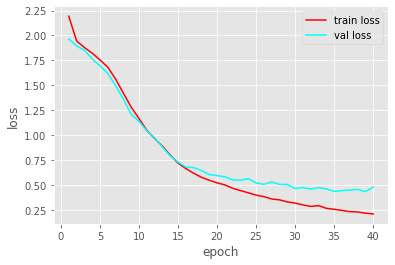

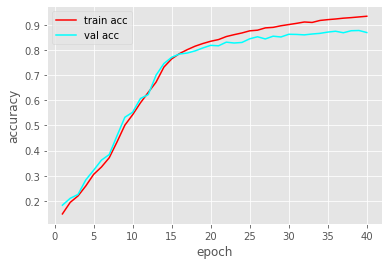

In [124]:
import matplotlib.pyplot as plt
# 训练集与测试集的loss和accuracy可视化

epoch_list = [(i + 1) for i in range(num_epochs)]

plt.style.use('ggplot')

# loss可视化
fig0 = plt.figure(0)
plt.plot(epoch_list, train_loss_list, label = 'train loss', color = 'red')
plt.plot(epoch_list, val_loss_list, label = 'val loss', color = 'cyan')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
plt.close(0)

# accuracy可视化
fig1 = plt.figure(1)
plt.plot(epoch_list, train_acc_list, label = 'train acc', color = 'red')
plt.plot(epoch_list, val_acc_list, label = 'val acc', color = 'cyan')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()
plt.close(1)

## 手写模块与封装模块的对比
&emsp;&emsp;除此之外，我们还用torch框架中的**`nn.Conv2d`**替换我们的Conv2D类进行了了训练。在参数不变的情况下，nn自带的卷积层训练结果更好，在经过10个epoch训练之后，验证集的准确率可以分别达到0.68左右。对比之下可以看出，相比于手写的Conv2D，nn中封装好的Conv2D中可能有一些特殊的处理或者优化能够使得准确率更快的提升到较高的水平。

# 基于ResNet18的训练模型

&emsp;&emsp;为了进一步提升准确率和探索其他卷积神经网络模型的效果，我们选择基于**ResNet**模型进行分析和改进。

&emsp;&emsp;对于最为基础的**ResNet18**模型，其包含一个$7\times 7$卷积层和4个残差块，其中第一个残差块输入输出通道数相同，步幅为1；后三个残差块输出通道是输入通道数的2倍，同时步幅为2，将图像分辨率压缩。最后连接全局平均汇聚层和一个全连接层。

&emsp;&emsp;由于**CIFAR-10数据集**中每个图像所转化而成的张量大小为[1, 3, 32, 32]，而非[1, 1, 224, 224]，所以我们对ResNet18网络在参数上进行微调，将最开始的$7\times 7$卷积层改为$3\times 3$卷积层，同时删去$2\times 2$的MaxPool层。

## 单个残差块的示意图
<!-- ![](Resblk.PNG) -->
![Resblk.PNG](https://s2.loli.net/2022/07/04/cZDSh2lJovkqz6b.png)
## 模型大致流程图
<!-- ![](Resnet18.PNG) -->
![Resnet18.PNG](https://s2.loli.net/2022/07/04/TSFdIE2z5NrfAul.png)

In [135]:
# 设计Residual类
class Residual(nn.Module):
    # 类初始化
    def __init__(self, input_channels, num_channels, use_1x1conv = False, strides = 1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size = 3, padding = 1, stride = strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size = 3, padding = 1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size = 1, stride = strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    # 网络函数定义（采用RELU激活函数）
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [136]:
# 设计单个ResNet块
def resnet_block(input_channels, num_channels, num_residuals, is_first_block = False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and is_first_block == False:
            blk.append(Residual(input_channels, num_channels, use_1x1conv = True, strides = 2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [137]:
# 设计ResNet网络模型
def ResNet(conv_res):
    b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size = 3, stride = 1, padding = 1),
                    nn.BatchNorm2d(64), nn.ReLU()
                    )
    resnet_blks = []
    now_channels = 64
    for i, (num_residuals, num_channels) in enumerate(conv_res):
        if(i == 0):
            resnet_blks.append(nn.Sequential(*resnet_block(now_channels, num_channels, num_residuals, is_first_block = True)))
        else :
            resnet_blks.append(nn.Sequential(*resnet_block(now_channels, num_channels, num_residuals)))
        now_channels = num_channels
    
    # b2 = nn.Sequential(*resnet_block(64, 64, 2, is_first_block = True))
    # b3 = nn.Sequential(*resnet_block(64, 128, 2))
    # b4 = nn.Sequential(*resnet_block(128, 256, 2))
    # b5 = nn.Sequential(*resnet_block(256, 512, 2))
    return nn.Sequential(b1,
                         *resnet_blks,
                        #  b2, b3, b4, b5,
                         nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
                         nn.Linear(512, 10)
                        )

In [138]:
# 定义学习率和迭代轮数
lr, num_epochs = 0.1, 40

# 定义网络结构
conv_res = [(2, 64), (2, 128), (2, 256), (2, 512)]
resnet18 = ResNet(conv_res)

# 训练过程
print('Using Model: ResNet-18')
time_st = time.perf_counter()
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_loss_list, train_acc_list = [], []
val_loss_list, val_acc_list = [], []
train(resnet18, train_iter, test_iter, num_epochs, lr, DEVICE, 'resnet')
time_ed = time.perf_counter()

# 计算时间
tot_time = time_ed - time_st
epo_time = tot_time / num_epochs

# 最终训练结果可视化
print('\n')
print('Time total:     ' + str(tot_time) + ' sec')
print('Time per epoch: ' + str(epo_time) + ' sec')

Using Model: ResNet-18
train on cuda
Epoch   1/40, train loss:  1.8946, train acc:  0.3275, val loss:  1.5121, val acc:  0.4411
Epoch   2/40, train loss:  1.3963, train acc:  0.4910, val loss:  1.2084, val acc:  0.5694
Epoch   3/40, train loss:  1.1138, train acc:  0.6027, val loss:  1.0234, val acc:  0.6377
Epoch   4/40, train loss:  0.9067, train acc:  0.6814, val loss:  0.8237, val acc:  0.7167
Epoch   5/40, train loss:  0.7460, train acc:  0.7390, val loss:  0.6870, val acc:  0.7613
Epoch   6/40, train loss:  0.6368, train acc:  0.7788, val loss:  0.6431, val acc:  0.7805
Epoch   7/40, train loss:  0.5577, train acc:  0.8075, val loss:  0.5855, val acc:  0.7999
Epoch   8/40, train loss:  0.4955, train acc:  0.8292, val loss:  0.5359, val acc:  0.8120
Epoch   9/40, train loss:  0.4524, train acc:  0.8434, val loss:  0.4972, val acc:  0.8310
Epoch  10/40, train loss:  0.4047, train acc:  0.8601, val loss:  0.4759, val acc:  0.8380
Epoch  11/40, train loss:  0.3708, train acc:  0.8719

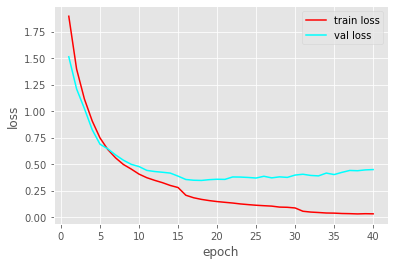

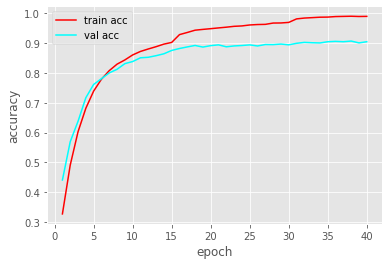

In [139]:
# 训练集与测试集的loss和accuracy可视化
import matplotlib.pyplot as plt

epoch_list = [(i + 1) for i in range(num_epochs)]

plt.style.use('ggplot')

# loss可视化
fig0 = plt.figure(0)
plt.plot(epoch_list, train_loss_list, label = 'train loss', color = 'red')
plt.plot(epoch_list, val_loss_list, label = 'val loss', color = 'cyan')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
plt.close(0)

# accuracy可视化
fig1 = plt.figure(1)
plt.plot(epoch_list, train_acc_list, label = 'train acc', color = 'red')
plt.plot(epoch_list, val_acc_list, label = 'val acc', color = 'cyan')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()
plt.close(1)

## 训练结果验证

&emsp;&emsp;为了使我们训练的成果可视化，更为直观的展现出来。我们从验证集中随机选出了30张图像，标出其正确的类别和用我们训练的模型预测的结果，若预测正确则为绿；否则为红。

In [140]:
import random

# 验证函数
def get_pred_visual(net):
    fig_cnt = 0
    features, targets = torch, torch.zeros(30)

    # 对数据集中十种分类进行命名
    label_name = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    # 获取测试集特征信息和目标结果
    for i, (test_X, test_y) in enumerate(test_iter):
        rand_inx = random.randint(1, batch_size) - 1
        if i != 0:
            features = torch.concat((features, torch.reshape(test_X[rand_inx], (1, 3, 32, 32))), dim = 0)
            targets[fig_cnt] = test_y[rand_inx]
        else :
            features = test_X[rand_inx]
            features = torch.reshape(features, (1, 3, 32, 32))
            targets[0] = test_y[rand_inx]
        fig_cnt += 1
        if(fig_cnt == 30):
            break

    net.eval()
    features = features.to(DEVICE)
    targets = targets.to(DEVICE)

    # 获取预测结果
    with torch.no_grad():
        predictions = net(features)
        predictions = torch.argmax(predictions, dim = 1)

    # 将预测与正确标签转化为int形式方便进行计算
    targets = targets.int()
    predictions = predictions.int()

    # 结果可视化
    fig_res = plt.figure(figsize = (50, 50))
    for i in range(30):
        plt.subplot(5, 6, i + 1)
        tmp = torch.Tensor.cpu(features[i])
        tmp = tmp.numpy()
        tmp = tmp.transpose((1, 2, 0))
        plt.imshow(tmp)
        titcol = ''
        if(targets[i] == predictions[i]):
            titcol = 'green'
        else:
            titcol = 'red'
        plt.title("Real: {}".format(label_name[targets[i]]) + '\n' + "Pred: {}".format(label_name[predictions[i]]), size = 30, color = titcol)
        
    # 绘图
    plt.show()
    plt.close(fig_res)

利用VGG16模型和ResNet-18模型的分类可视化结果分别如下：

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

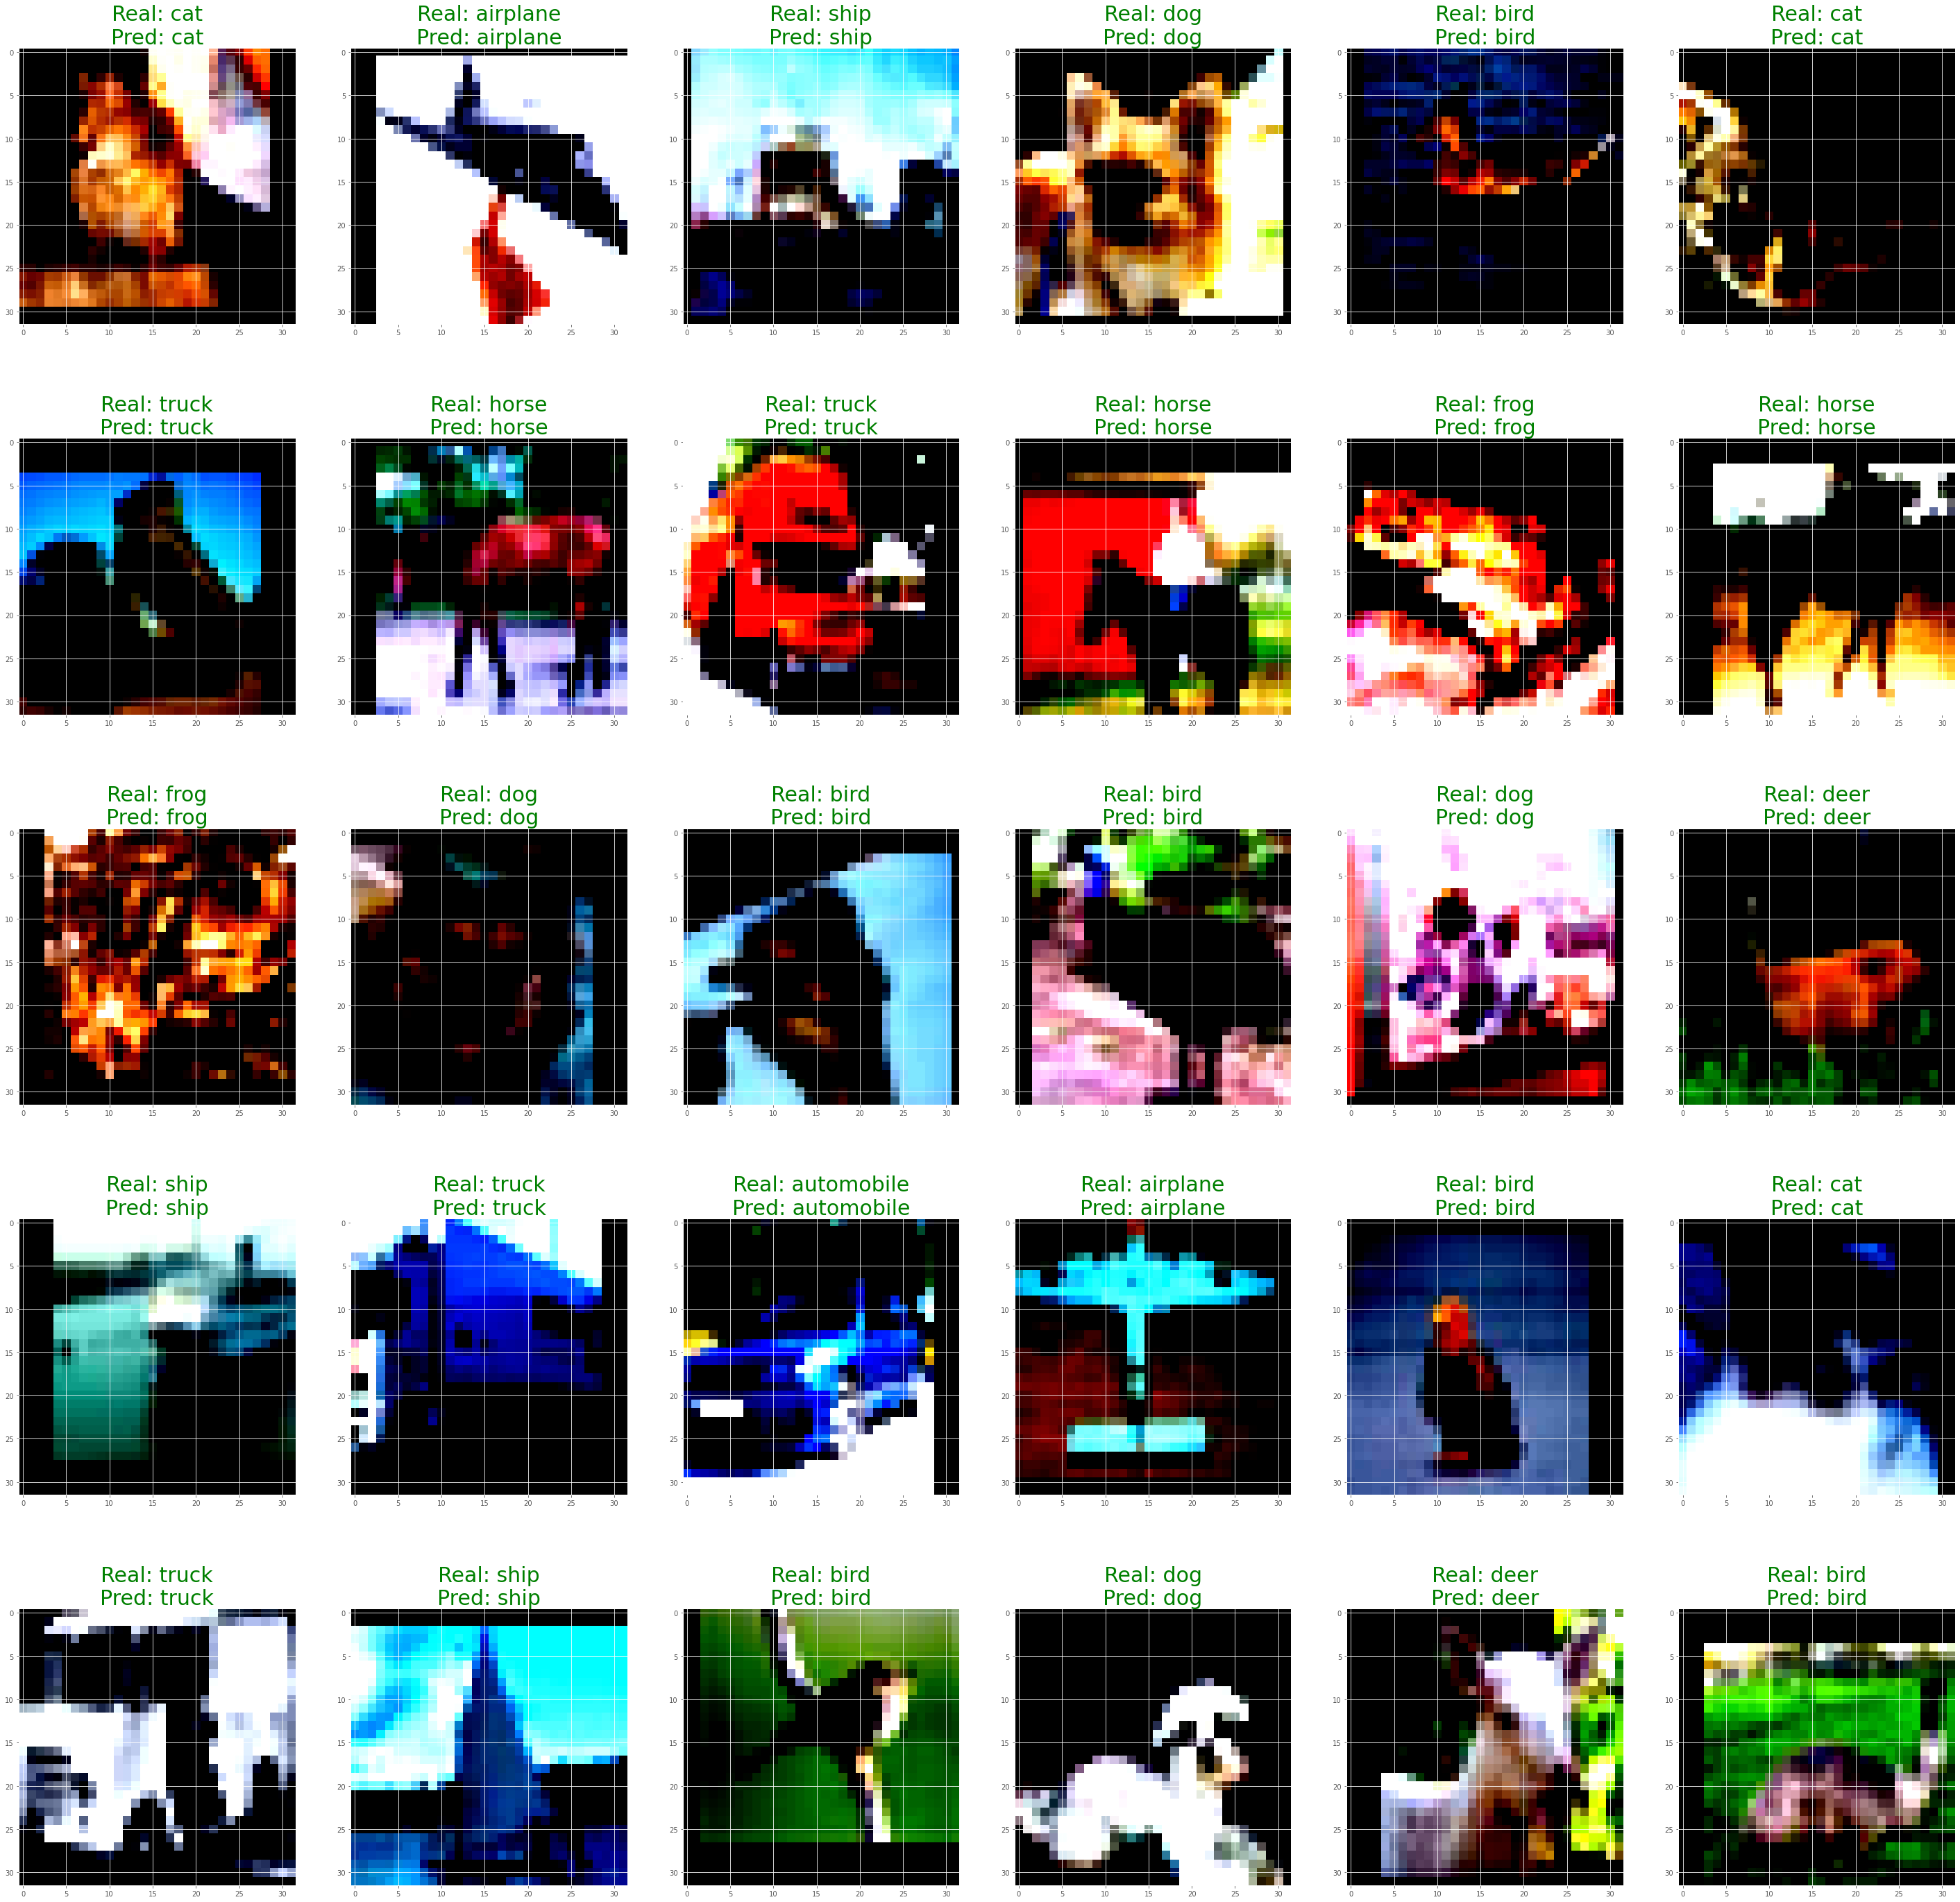

In [141]:
# get_pred_visual(VGG16)
get_pred_visual(resnet18)

# 总结与心得
&emsp;&emsp;本次作业中，我首先尝试了课上所讲的VGG11模型。模型基本在第12轮左右的训练中就达到了近似最佳的测试集分类准确率，之后loss虽有下降且训练集的准确率略有上升，但是测试集的准确率基本都在0.7左右上下波动，说明此时过拟合较为严重。

&emsp;&emsp;考虑到由于VGG11模型还较为简单，其提取图像中关键信息的能力相比VGG16和VGG19还较弱，故我将模型换成VGG16和VGG19并根据CIFAR-10数据集的特点调整了输入、输出通道数和卷积核的大小。最终发现在相同的学习率、批量大小、学习周期的条件下，VGG16和VGG19对测试集的分类准确率无明显差别，而VGG16训练速度较快，所用时间较短，故最终在报告中留下了VGG16模型。

&emsp;&emsp;为了进一步提高分类准确率，我在每个VGG块中加入了批量标准化（Batch Normalization），在其他条件不改变的情况下，准确率由0.75提升到了0.80。
后来加入了`torchvision.transform`对CIFAR图像进行了预处理，并对于学习率、批量大小进行了多次调整，最终将学习率lr定为0.05、batch_size定为128，此时准确率由0.80提升到了0.88左右，效果提升明显。

&emsp;&emsp;在这一过程中，我曾经还将VGG块中的非底层的卷积层中普通的卷积改为深度可分离卷积，但是训练效率提高的同时准确率有所下降，故最后没有采用。

&emsp;&emsp;在ResNet-18模型中，还是像上面一样先将`train_dataset`和`test_dataset`都进行`transform`预处理（主要是标准化）。调参中可以发现，测试集的准确率在开始阶段提升较为明显，但是后期在小范围上下波动，过拟合现象变严重，可能是因为学习率较大而无法接近更优值。故在此之上，增加了`torch.optim.lr_scheduler.StepLR`进行学习率的调整。